# Znailla Bank Marketing Campaign - ML Model

Predicting Term Deposit Subscription to Reduce Call Center Costs

## Load Dataset and Initial Setup

In [17]:
import numpy as np
import pandas as pd
import missingno
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2

In [10]:
# Load dataset
data = pd.read_csv(r'../data\raw\bank-additional-full.csv', sep=';')
# data['y'] = data['y'].map({'yes': 1, 'no': 0})
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


## Exploratory Feature Analysis

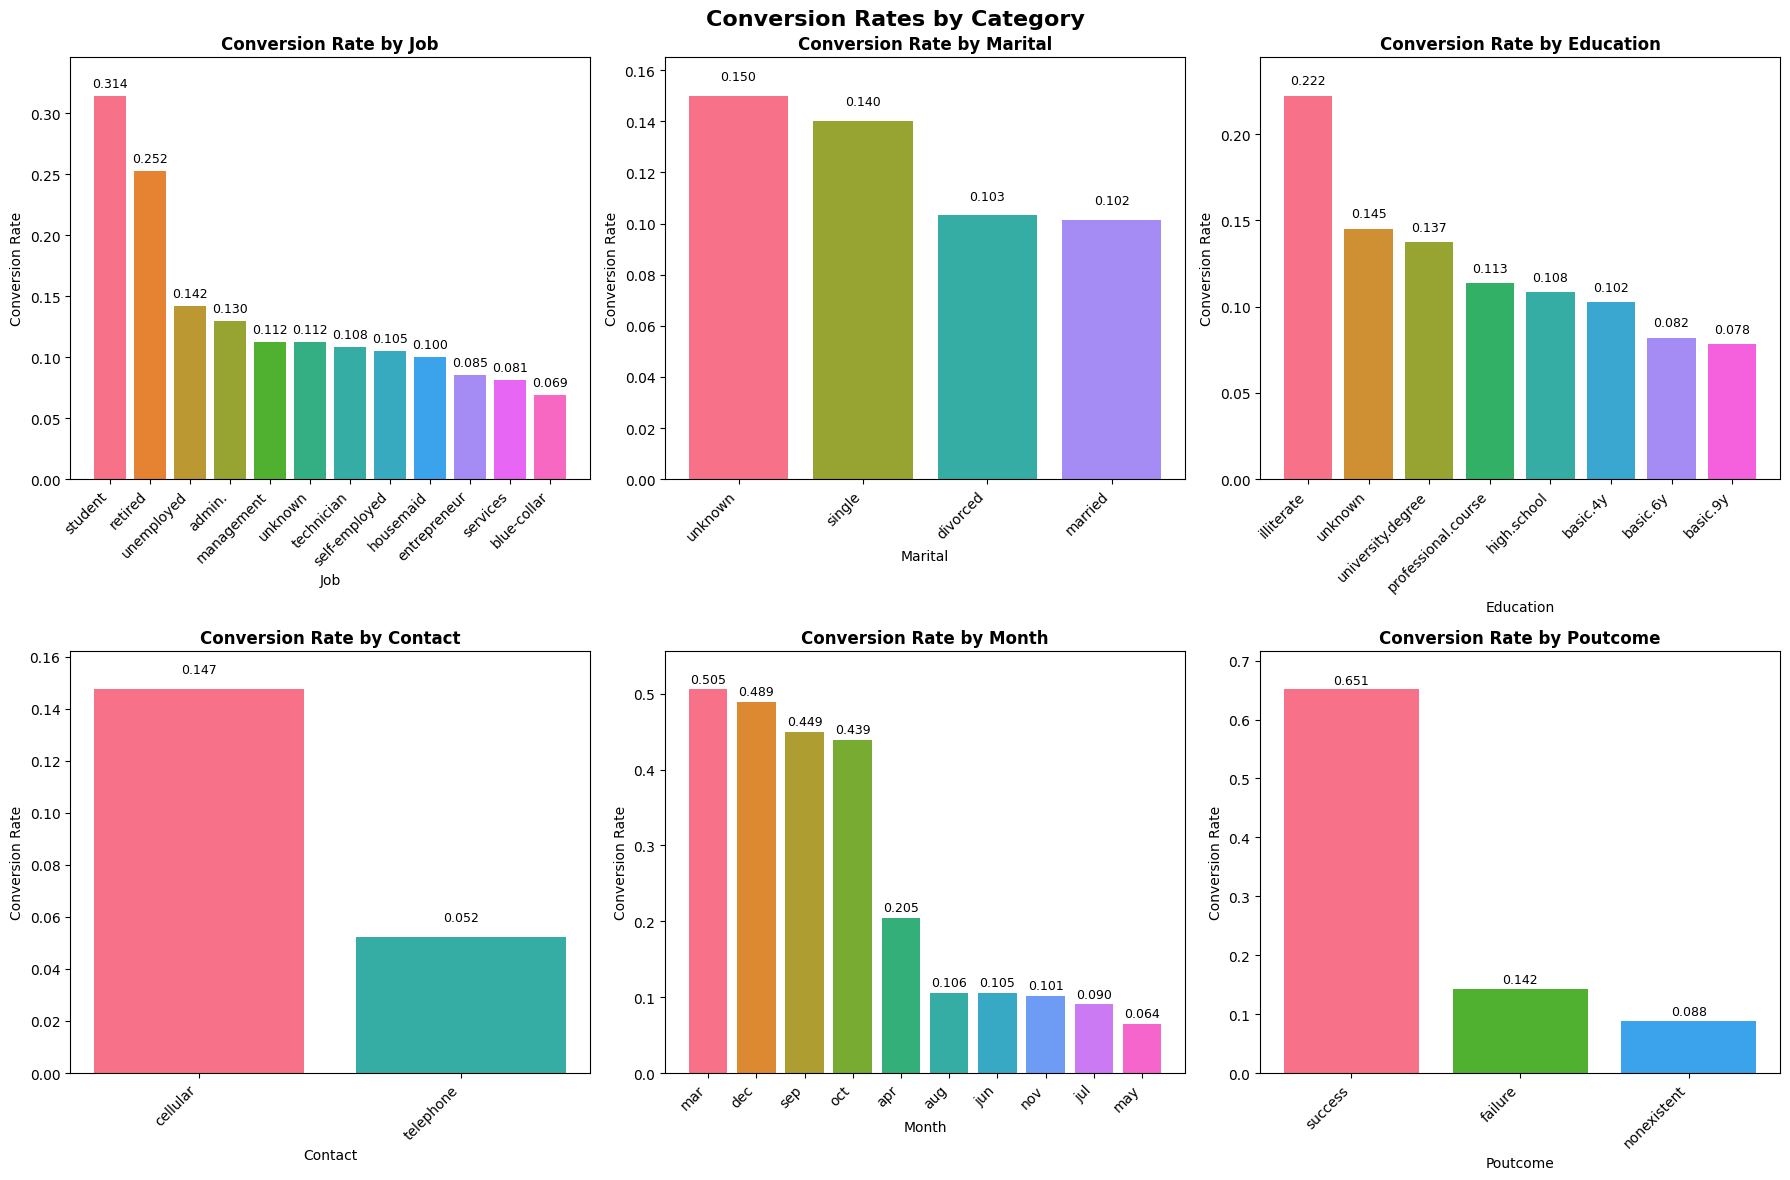


TOP PERFORMERS BY CATEGORY

Top 3 in job:
  student: 0.314 (31.4%)
  retired: 0.252 (25.2%)
  unemployed: 0.142 (14.2%)

Top 3 in marital:
  unknown: 0.150 (15.0%)
  single: 0.140 (14.0%)
  divorced: 0.103 (10.3%)

Top 3 in education:
  illiterate: 0.222 (22.2%)
  unknown: 0.145 (14.5%)
  university.degree: 0.137 (13.7%)

Top 3 in contact:
  cellular: 0.147 (14.7%)
  telephone: 0.052 (5.2%)

Top 3 in month:
  mar: 0.505 (50.5%)
  dec: 0.489 (48.9%)
  sep: 0.449 (44.9%)

Top 3 in poutcome:
  success: 0.651 (65.1%)
  failure: 0.142 (14.2%)
  nonexistent: 0.088 (8.8%)


In [13]:
# Convert target variable to numeric (assuming 'yes' = 1, 'no' = 0)
if data['y'].dtype == 'object':
    data['y_numeric'] = data['y'].map({'yes': 1, 'no': 0})
    target_col = 'y_numeric'
else:
    target_col = 'y'

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for all categorical variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Conversion Rates by Category', fontsize=16, fontweight='bold')

# Flatten axes for easier iteration
axes = axes.flatten()

# Conversion rate by category with visualization
categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

for i, col in enumerate(categorical_cols):
    # Calculate conversion rates using the numeric target column
    conversion_rates = data.groupby(col)[target_col].mean().sort_values(ascending=False)
    
    # Create bar plot
    ax = axes[i]
    bars = ax.bar(range(len(conversion_rates)), conversion_rates.values, 
                  color=sns.color_palette("husl", len(conversion_rates)))
    
    # Customize the plot
    ax.set_title(f'Conversion Rate by {col.title()}', fontweight='bold')
    ax.set_xlabel(col.title())
    ax.set_ylabel('Conversion Rate')
    ax.set_xticks(range(len(conversion_rates)))
    ax.set_xticklabels(conversion_rates.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Set y-axis to show percentages
    ax.set_ylim(0, max(conversion_rates.values) * 1.1)

plt.tight_layout()
plt.show()

# Additional: Create a summary heatmap showing top performers in each category
print("\n" + "="*50)
print("TOP PERFORMERS BY CATEGORY")
print("="*50)

top_performers = {}
for col in categorical_cols:
    conversion_rates = data.groupby(col)[target_col].mean().sort_values(ascending=False)
    top_performers[col] = conversion_rates.head(3)
    print(f"\nTop 3 in {col}:")
    for category, rate in conversion_rates.head(3).items():
        print(f"  {category}: {rate:.3f} ({rate*100:.1f}%)")


In [15]:
# Correlation with numeric features
print('Correlation with y:')
print(data.corr(numeric_only=True)['y_numeric'].sort_values(ascending=False))

Correlation with y:
y_numeric         1.000000
duration          0.405274
previous          0.230181
cons.conf.idx     0.054878
age               0.030399
campaign         -0.066357
cons.price.idx   -0.136211
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354678
Name: y_numeric, dtype: float64


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import pandas as pd

# First, let's properly encode categorical variables
categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

# Check which columns actually exist in the dataset
existing_cols = [col for col in categorical_cols if col in data.columns]

# Create a copy of the data for encoding
X_cat = data[existing_cols].copy()

# Properly encode each categorical column
label_encoders = {}
for col in existing_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col].astype(str))
    label_encoders[col] = le


# Make sure we have the target variable
if 'y_numeric' not in data.columns:
    # Create y_numeric if it doesn't exist
    if 'y' in data.columns:
        data['y_numeric'] = data['y'].map({'yes': 1, 'no': 0})
    else:
        print("Please specify the correct target column name")
        print("Available columns:", data.columns.tolist())

# Perform chi-squared test
try:
    chi_scores, p_values = chi2(X_cat, data['y_numeric'])
    
    # Create results dataframe
    chi_results = pd.DataFrame({
        'feature': X_cat.columns, 
        'chi2_score': chi_scores, 
        'p_value': p_values
    })
    
    # Sort by chi-squared score (descending)
    chi_results = chi_results.sort_values('chi2_score', ascending=False)
    
    # Interpretation
    print("\nFeature importance based on Chi-squared scores:")
    for idx, row in chi_results.iterrows():
        significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
        print(f"{row['feature']}: {row['chi2_score']:.2f} (p={row['p_value']:.4f}) {significance}")
    
except Exception as e:
    print(f"Error in chi-squared test: {e}")
    print("Let's check the data types and values:")
    print(f"X_cat shape: {X_cat.shape}")
    print(f"X_cat dtypes:\n{X_cat.dtypes}")
    print(f"Target variable unique values: {data['y_numeric'].unique()}")
    print(f"Any missing values in X_cat: {X_cat.isnull().sum().sum()}")
    print(f"Any missing values in target: {data['y_numeric'].isnull().sum()}")



Feature importance based on Chi-squared scores:
contact: 547.96 (p=0.0000) ***
education: 167.61 (p=0.0000) ***
poutcome: 98.23 (p=0.0000) ***
job: 90.18 (p=0.0000) ***
marital: 27.80 (p=0.0000) ***
month: 1.93 (p=0.1651) 


## Data Cleaning

In [74]:
data = data.replace('unknown', np.nan)
data.isna().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

<Axes: >

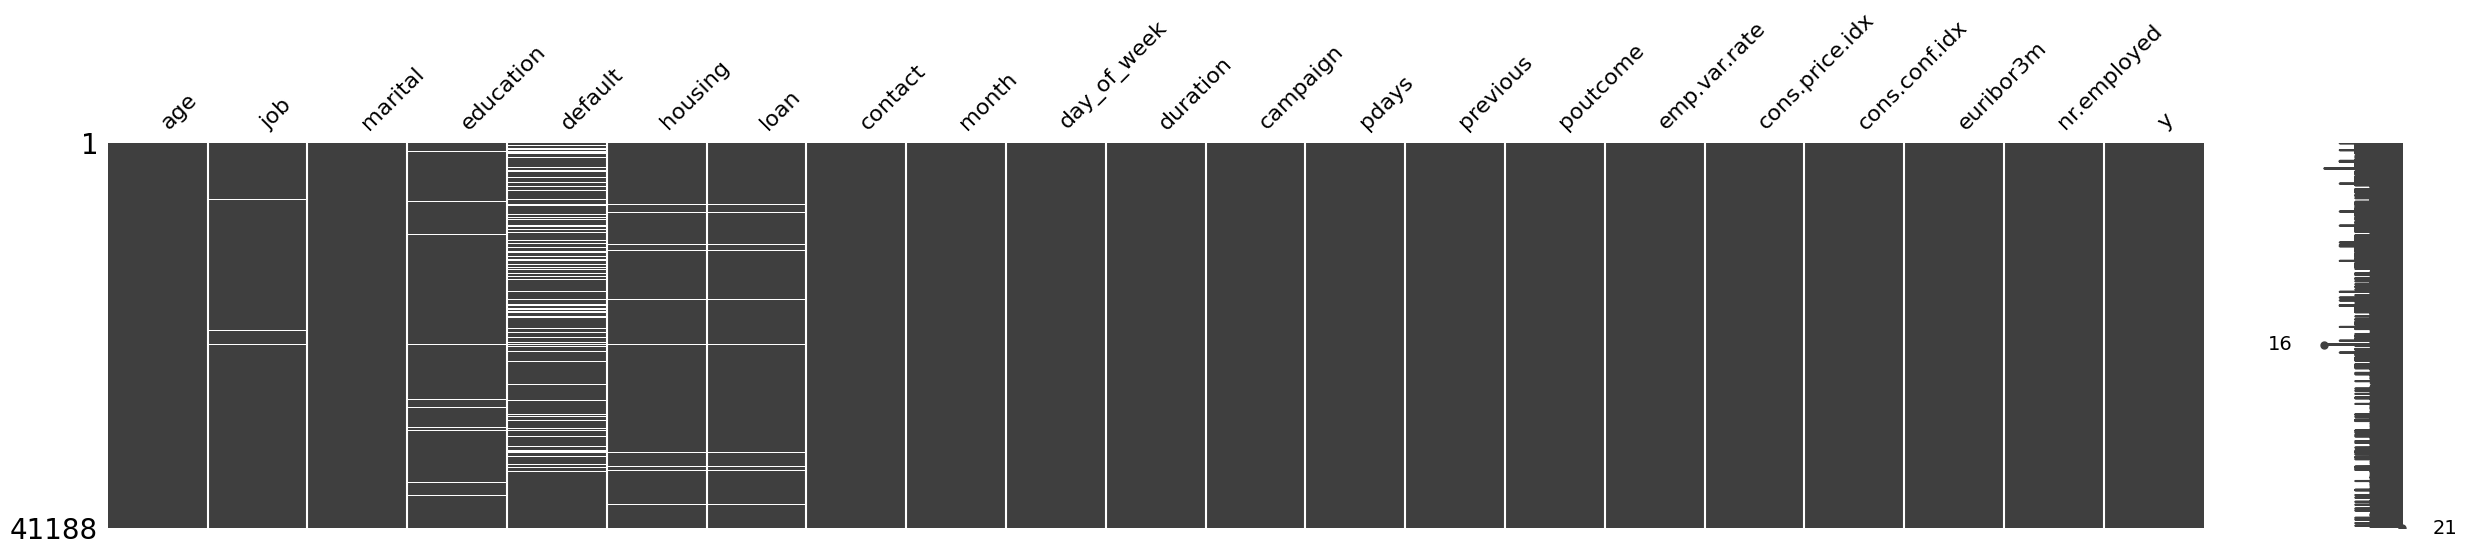

In [75]:
missingno.matrix(data, figsize = (30,5))

In [76]:
data['education'] = data['education'].fillna(data['education'].mode()[0])
data['job'] = data['job'].fillna(data['job'].mode()[0])
data['marital'] = data['marital'].fillna(data['marital'].mode()[0])
data['housing'] = data['housing'].fillna(data['housing'].mode()[0])
data['default'] = data['default'].fillna(data['default'].mode()[0])
data.replace({"no":0, "yes":1}, inplace=True)

C:\Users\ahmed.nani\AppData\Local\Temp\ipykernel_21220\3703335631.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"no":0, "yes":1}, inplace=True)


<Axes: >

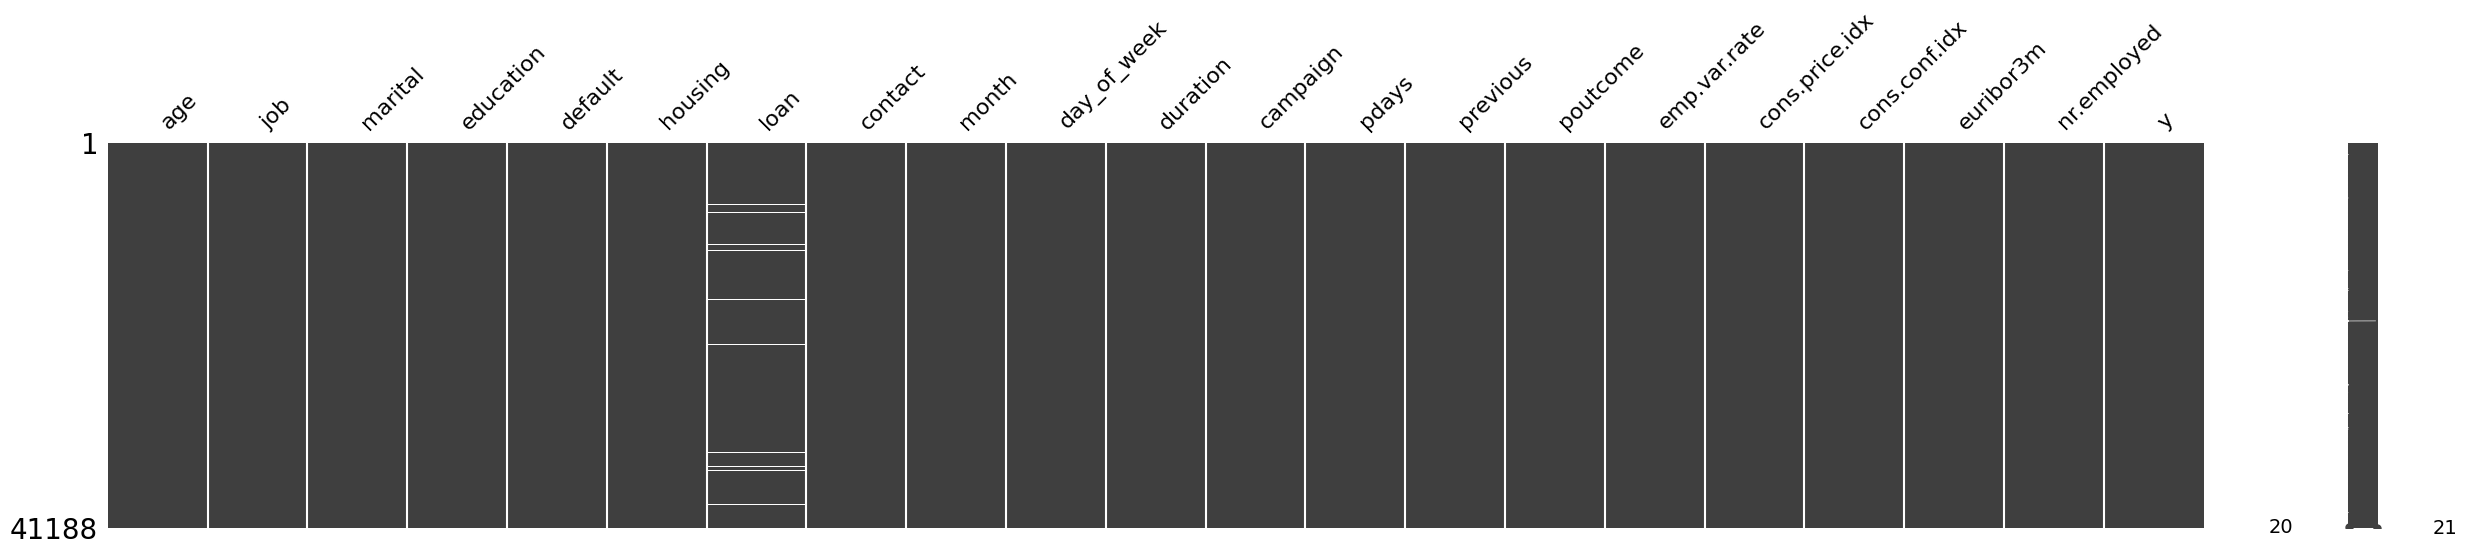

In [77]:
missingno.matrix(data, figsize = (30,5))

In [78]:
data['loan'].fillna(data['loan'].mean(), inplace = True)

C:\Users\ahmed.nani\AppData\Local\Temp\ipykernel_21220\1445539005.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['loan'].fillna(data['loan'].mean(), inplace = True)


In [79]:
# Create new binary features
data['recent_contact'] = (data['pdays'] != 999).astype(int)
data['many_contacts'] = (data['previous'] > 2).astype(int)
data['long_campaign'] = (data['campaign'] > data['campaign'].median()).astype(int)
data['contacted_in_may'] = (data['month'] == 'may').astype(int)
data['is_student_or_retired'] = data['job'].isin(['student', 'retired']).astype(int)
data['was_success_before'] = (data['poutcome'] == 'success').astype(int)

print("Engineered features:")
engineered_features = ['recent_contact', 'many_contacts', 'long_campaign', 'contacted_in_may', 'is_student_or_retired', 'was_success_before']
print(data[engineered_features].head())

print("\nEngineered feature conversion rates:")
for col in ['recent_contact', 'many_contacts', 'long_campaign', 'contacted_in_may', 'is_student_or_retired', 'was_success_before']:
    print(f"{col}:\n{data.groupby(col)['y'].mean()}\n")

Engineered features:
   recent_contact  many_contacts  long_campaign  contacted_in_may  \
0               0              0              0                 1   
1               0              0              0                 1   
2               0              0              0                 1   
3               0              0              0                 1   
4               0              0              0                 1   

   is_student_or_retired  was_success_before  
0                      0                   0  
1                      0                   0  
2                      0                   0  
3                      0                   0  
4                      0                   0  

Engineered feature conversion rates:
recent_contact:
recent_contact
0    0.092582
1    0.638284
Name: y, dtype: float64

many_contacts:
many_contacts
0    0.109056
1    0.587097
Name: y, dtype: float64

long_campaign:
long_campaign
0    0.124451
1    0.087007
Name: y, dtype: float

In [80]:
train, test = train_test_split(data, test_size=0.2, random_state=42)


global_mean = train['y'].mean()
numerical_variables = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx','euribor3m', 'nr.employed']
categorical_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

for col in categorical_cols:
    mean_map = train.groupby(col)['y'].mean().to_dict()
    train[col + '_mean_enc'] = train[col].map(mean_map)
    test[col + '_mean_enc'] = test[col].map(mean_map).fillna(global_mean)

In [81]:
encoded_features = [col + '_mean_enc' for col in categorical_cols]
train = train[encoded_features+numerical_variables+engineered_features + ['y']]
test = test[encoded_features+numerical_variables+engineered_features + ['y']]

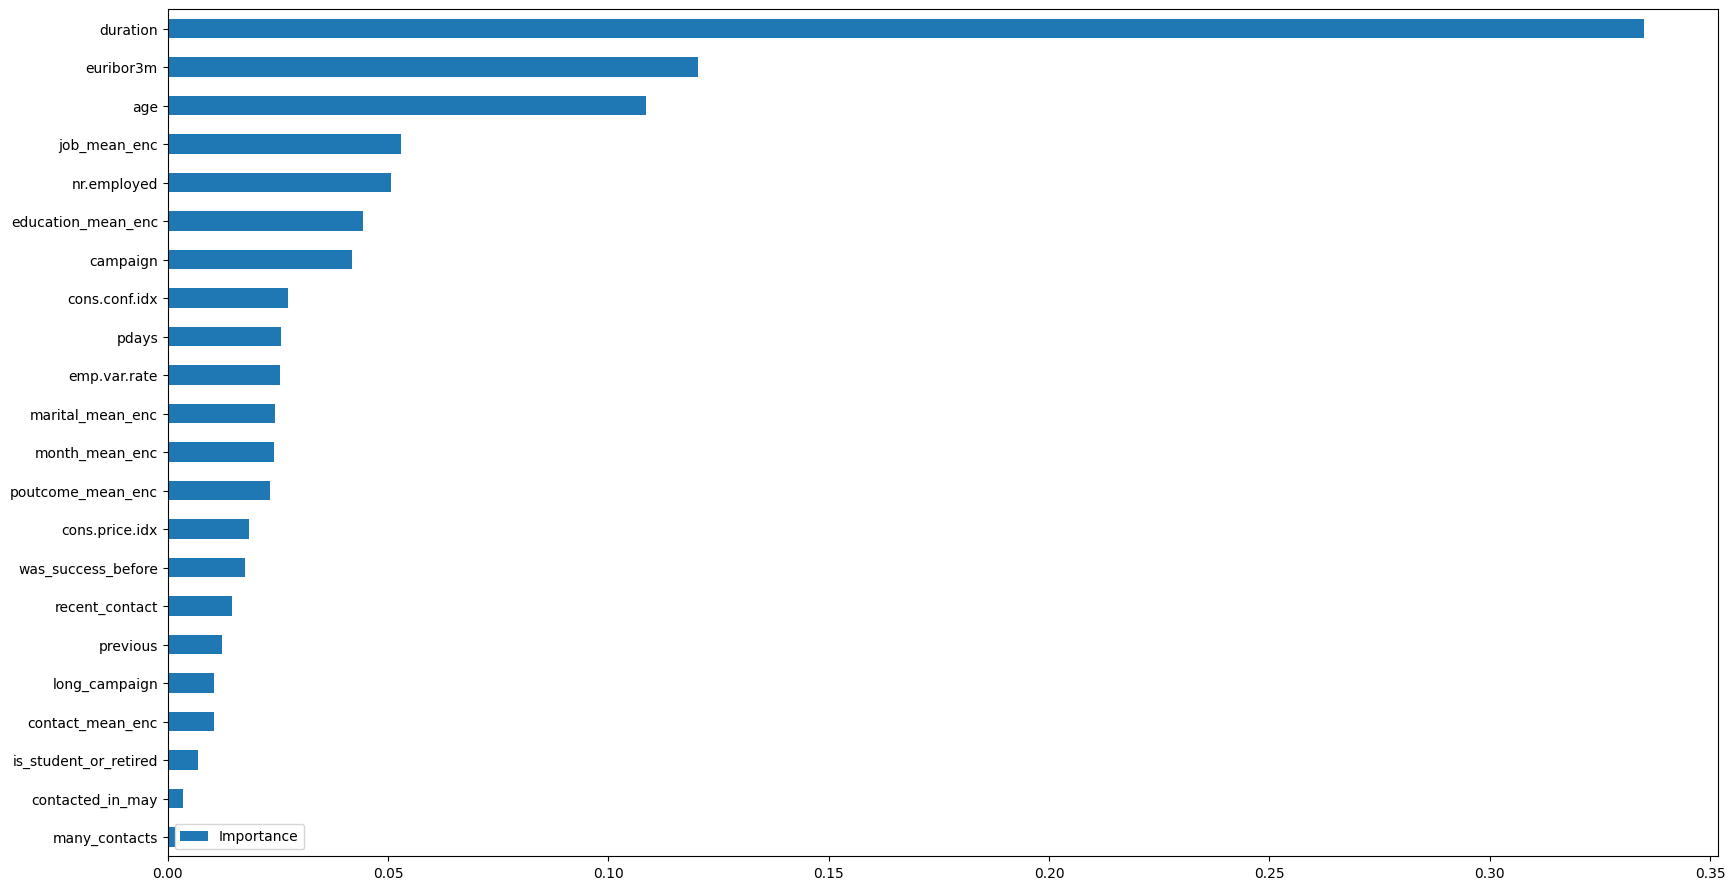

In [82]:
# Using Random Forest to gain an insight on Feature Importance

clf = RandomForestClassifier()
clf.fit(train.drop(columns=['y']), train['y'])

# plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=train.drop('y', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

We can see that duration is a big teller on the target and we already know that we have to remove it if the goal is to have a realistic predictive model.

In [83]:
train = train.drop(columns=['duration'])
test = test.drop(columns=['duration'])

X_train = train.drop(columns=['y'])
y_train = train['y']
X_test = test.drop(columns=['y'])
y_test = test['y']

In [84]:
estimator = RandomForestClassifier(random_state=42)

rfecv = RFECV(estimator=estimator, min_features_to_select=10, scoring='accuracy')
rfecv.fit(X_train, y_train)

# Selected features mask
selected_mask = rfecv.support_
selected_features = X_train.columns[selected_mask]
print(f"Selected features are {len(selected_features)}: {', '.join(selected_features)}")

# Filter only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

Selected features are 20: job_mean_enc, marital_mean_enc, education_mean_enc, contact_mean_enc, month_mean_enc, poutcome_mean_enc, age, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, recent_contact, long_campaign, contacted_in_may, is_student_or_retired, was_success_before


In [85]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_resample(X_train, y_train.values.ravel())

print("X Train:", X_train.shape)
print("X Test:", X_test.shape)
print("Y Train:", y_train.shape)
print("Y Test:", y_test.shape)

X Train: (58490, 20)
X Test: (8238, 20)
Y Train: (58490,)
Y Test: (8238,)


In [87]:
from sklearn.svm import SVC
from lightgbm import LGBMClassifier



lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
# svm = SVC(probability=True, kernel='rbf', class_weight='balanced', random_state=42)
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)

models = [
    lr,
    rf,
    gb,
    xgb,
    lgbm
]
print("Training the models...")

for model in models:
    model.fit(X_train, y_train)
    print(f"{model.__class__.__name__} trained.")

print("Models trained.")
# Make predictions
for model in models:
    model_name = model.__class__.__name__
    y_pred = model.predict(X_test)
    print(f"{model_name} accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(f"{model_name} precision: {precision_score(y_test, y_pred):.4f}")
    print(f"{model_name} recall: {recall_score(y_test, y_pred):.4f}")
    print(f"{model_name} f1: {f1_score(y_test, y_pred):.4f}")
    print("\n")


Training the models...


c:\Users\ahmed.nani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression trained.
RandomForestClassifier trained.
GradientBoostingClassifier trained.


c:\Users\ahmed.nani\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:24:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier trained.
[LightGBM] [Info] Number of positive: 29245, number of negative: 29245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 58490, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBMClassifier trained.
Models trained.
LogisticRegression accuracy: 83.30%
LogisticRegression precision: 0.3531
LogisticRegression recall: 0.5668
LogisticRegression f1: 0.4351


RandomForestClassifier accuracy: 87.65%
RandomForestClassifier precision: 0.4456
RandomForestClassifier recall: 0.3594
RandomForestClassifier f1: 0.3979


GradientBoostingClassifier accuracy: 88.12%
GradientBoostingClassifier precision: 0.4736
GradientBoostingClassifier recall: 0.4225
GradientB

In [96]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Training and test data assumed to be defined: X_train, X_test, y_train, y_test

f1 = make_scorer(f1_score)
balanced_f1_scorer = make_scorer(f1_score, average='macro')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define search spaces
search_spaces = {
    'LogisticRegression': {
        'LogisticRegression__C': Real(0.01, 10, prior='log-uniform'),
        'LogisticRegression__penalty': Categorical(['l2']),
        'LogisticRegression__solver': Categorical(['lbfgs', 'saga'])
    },
    'RandomForestClassifier': {
        'RandomForestClassifier__n_estimators': Integer(50, 200),
        'RandomForestClassifier__max_depth': Integer(3, 20),
        'RandomForestClassifier__min_samples_split': Integer(2, 10),
        'RandomForestClassifier__min_samples_leaf': Integer(1, 10)
    },
    'GradientBoostingClassifier': {
        'GradientBoostingClassifier__n_estimators': Integer(50, 200),
        'GradientBoostingClassifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'GradientBoostingClassifier__max_depth': Integer(3, 10),
        'GradientBoostingClassifier__subsample': Real(0.5, 1.0)
    },
    'XGBClassifier': {
        'XGBClassifier__n_estimators': Integer(50, 200),
        'XGBClassifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'XGBClassifier__max_depth': Integer(3, 10),
        'XGBClassifier__subsample': Real(0.5, 1.0),
        'XGBClassifier__colsample_bytree': Real(0.5, 1.0)
    },
    'LGBMClassifier': {
        'LGBMClassifier__num_leaves': Integer(20, 50),
        'LGBMClassifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'LGBMClassifier__n_estimators': Integer(50, 200),
        'LGBMClassifier__min_child_samples': Integer(5, 30),
        'LGBMClassifier__subsample': Real(0.5, 1.0),
        'LGBMClassifier__colsample_bytree': Real(0.5, 1.0)
    },
    'BaggingClassifier': {
        'BaggingClassifier__n_estimators': Integer(10, 100),
        'BaggingClassifier__max_samples': Real(0.5, 1.0),
        'BaggingClassifier__max_features': Real(0.5, 1.0)
    },
    'HistGradientBoostingClassifier': {
        'HistGradientBoostingClassifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'HistGradientBoostingClassifier__max_iter': Integer(50, 200),
        'HistGradientBoostingClassifier__max_depth': Integer(3, 10)
    }
}

# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    # 'XGBClassifier': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    # 'LGBMClassifier': LGBMClassifier(random_state=42),
    'BaggingClassifier': BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'), random_state=42),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(class_weight='balanced', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nStarting Bayesian Optimization for {name.upper()}...")

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        (name, model)
    ])

    opt = BayesSearchCV(
        estimator=pipe,
        search_spaces=search_spaces[name],
        scoring=balanced_f1_scorer,
        n_iter=30,
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    opt.fit(X_train, y_train)

    y_pred = opt.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    balanced_f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Best F1 (CV) for {name.upper()}: {opt.best_score_:.4f}")
    print(f"Test F1 for {name.upper()}: {test_f1:.4f}")
    print(f"Balanced F1 (macro): {balanced_f1:.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Best Params: {opt.best_params_}")

    results[name] = {
        'best_estimator': opt.best_estimator_,
        'best_score_cv': opt.best_score_,
        'test_f1': test_f1,
        'balanced_f1': balanced_f1,
        'test_accuracy': accuracy_score(y_test, y_pred),
        'best_params': opt.best_params_
    }



Starting Bayesian Optimization for LOGISTICREGRESSION...
Best F1 (CV) for LOGISTICREGRESSION: 0.7509
Test F1 for LOGISTICREGRESSION: 0.4345
Balanced F1 (macro): 0.6638
Test Accuracy: 0.8202
Best Params: OrderedDict({'LogisticRegression__C': 0.4926326008420885, 'LogisticRegression__penalty': 'l2', 'LogisticRegression__solver': 'lbfgs'})

Starting Bayesian Optimization for RANDOMFORESTCLASSIFIER...
Best F1 (CV) for RANDOMFORESTCLASSIFIER: 0.9328
Test F1 for RANDOMFORESTCLASSIFIER: 0.4175
Balanced F1 (macro): 0.6753
Test Accuracy: 0.8801
Best Params: OrderedDict({'RandomForestClassifier__max_depth': 20, 'RandomForestClassifier__min_samples_leaf': 1, 'RandomForestClassifier__min_samples_split': 2, 'RandomForestClassifier__n_estimators': 200})

Starting Bayesian Optimization for BAGGINGCLASSIFIER...
Best F1 (CV) for BAGGINGCLASSIFIER: 0.9409
Test F1 for BAGGINGCLASSIFIER: 0.4172
Balanced F1 (macro): 0.6782
Test Accuracy: 0.8898
Best Params: OrderedDict({'BaggingClassifier__max_features': 0

## Model Evaluation and Business Metrics

In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Core metrics
y_pred = results['BaggingClassifier']['best_estimator'].predict(X_test)

# Core metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

# Confusion matrix and components
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Business assumptions
cost_per_call = 8
gain_per_success = 80

# Business metrics
total_contacts = len(y_test)
total_positives = y_test.sum()
profit_all = (total_positives * gain_per_success) - (total_contacts * cost_per_call)
profit_model = (tp * gain_per_success) - ((tp + fp) * cost_per_call)
cost_savings = tn * cost_per_call
potential_profit = total_positives * gain_per_success
profit_efficiency = (profit_model / potential_profit) * 100

# === OUTPUT ===

print("=== MODEL PERFORMANCE ===")
print(f"Accuracy:    {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Precision:   {precision:.3f} ({precision*100:.1f}%)")
print(f"Recall:      {recall:.3f} ({recall*100:.1f}%)")
print(f"Specificity: {specificity:.3f} ({specificity*100:.1f}%)")
print(f"F1 Score:    {f1:.3f}")

print("\n=== CONFUSION MATRIX ===")
print(f"                 Predicted")
print(f"                No    Yes")
print(f"Actual  No     {tn:4d}  {fp:4d}")
print(f"        Yes    {fn:4d}  {tp:4d}")

print("\n=== BUSINESS METRICS ===")
print(f"Profit if calling ALL customers:  €{profit_all:,.2f}")
print(f"Profit using model predictions:   €{profit_model:,.2f}")
print(f"Improvement from model:           €{profit_model - profit_all:,.2f}")
print(f"Cost savings from avoided calls:  €{cost_savings:,.2f}")
print(f"Total business value delivered:   €{profit_model + cost_savings:,.2f}")
print(f"Maximum possible profit:          €{potential_profit:,.2f}")
print(f"Profit efficiency:                {profit_efficiency:.1f}%")

print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=["No Subscription", "Subscription"]))


=== MODEL PERFORMANCE ===
Accuracy:    0.890 (89.0%)
Precision:   0.522 (52.2%)
Recall:      0.348 (34.8%)
Specificity: 0.959 (95.9%)
F1 Score:    0.678

=== CONFUSION MATRIX ===
                 Predicted
                No    Yes
Actual  No     7005   298
        Yes     610   325

=== BUSINESS METRICS ===
Profit if calling ALL customers:  €8,896.00
Profit using model predictions:   €21,016.00
Improvement from model:           €12,120.00
Cost savings from avoided calls:  €56,040.00
Total business value delivered:   €77,056.00
Maximum possible profit:          €74,800.00
Profit efficiency:                28.1%

=== DETAILED CLASSIFICATION REPORT ===
                 precision    recall  f1-score   support

No Subscription       0.92      0.96      0.94      7303
   Subscription       0.52      0.35      0.42       935

       accuracy                           0.89      8238
      macro avg       0.72      0.65      0.68      8238
   weighted avg       0.87      0.89      0.88      82

### 📊 Business Metrics

- **Profit if calling ALL customers :** €8,896.00  
- **Profit using model predictions :**  €21,016.00  
- **Improvement from model :**          €12,120.00  
- **Cost savings from avoided calls :** €56,040.00  
- **Total business value delivered :**  €77,056.00  
- **Profit efficiency :**               28.1%





## 🔍 Key Drivers of Conversion (Based on Model Insights)

### 1. 📅 Month of Contact
- Conversion rates were **significantly higher** in **March, December, and October**.
- Likely due to seasonal behaviors or financial planning cycles.

### 2. 🔁 Outcome of Previous Campaign (`poutcome`)
- Customers with a **previous successful interaction** had a much **higher likelihood of converting** again.
- Indicates strong behavioral momentum or positive prior engagement.

### 3. 📞 Type of Contact
- **Cellular** contact showed better conversion than **telephone** (landline).
- Suggests that mobile outreach may reach customers at more convenient times or signals better accessibility.

### 4. 👨‍🎓 Job Type
- **Students and retirees** had notably **higher conversion rates**.
- Indicates they might be more receptive to long-term financial planning products.

### 5. 🎓 Education Level
- Customers with **tertiary education** were more likely to subscribe.
- Suggests education level correlates with product understanding or trust.

---

These findings help build a data-driven approach to **select weekly cohorts of customers** who are:
- Most likely to convert based on these predictive features.
- Actionable for real-time prioritization and cost-saving contact decisions.


## Model Insights and Recommendations

### 🧠 Business Insights from the Model

#### 1. Month of Contact Strongly Affects Conversion
- **March, December, and October** showed the **highest conversion rates**.
- **Implication**: Campaigns run in these months are more effective, possibly due to seasonal behavior or financial cycles.

**➡️ Recommendation**: Prioritize marketing efforts in March, December, and October to improve subscription rates.

---

#### 2. Previous Campaign Outcome is Highly Predictive
- Customers with a **previous successful outcome (`poutcome = success`)** are far more likely to convert again.

**➡️ Recommendation**: Retarget individuals who previously responded positively — they are prime candidates for future campaigns.

---

#### 3. Contact Method Matters
- **Cellular contact** outperformed **telephone** in conversion effectiveness.

**➡️ Recommendation**: Focus outreach via **cellular** channels rather than traditional landlines.

---

#### 4. Job Type Indicates Propensity to Convert
- **Students and retirees** showed **higher-than-average conversion rates**.
- **Blue-collar workers** and **unknown job types** had lower conversion.

**➡️ Recommendation**: Tailor messaging and prioritize follow-ups for professions with higher conversion potential (e.g., retirees, students).

---

#### 5. Education Level Plays a Role
- The **illiterate** and individuals with **tertiary education** had better conversion rates than those with only basic education.

**➡️ Recommendation**: Personalize campaign messaging to appeal to more educated segments, emphasizing financial benefits and trust.

---

#### 6. Campaigns After Contact Success Tend to Perform Better
- Campaigns that followed a **“success” outcome in the past** have a significantly higher ROI.

**➡️ Recommendation**: Create a **“warm lead” list** from previous campaign results and target them with follow-up offers.
